# Using `biolord-classify` pipeline

Here we train a `biolord-classify` model on the spatio-temporally resolved single cell atlas of the Plasmodium liver stage {cite}`afriat:22` to extend the classification of `Abortive state` (provided for 36 hpi) to earlier stages of infection (24 and 30 hpi).

In [1]:
import pandas as pd
import numpy as np

import scanpy as sc
from scipy.stats import ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import biolord

from statannotations.Annotator import Annotator

[rank: 0] Global seed set to 0


In [2]:
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Setup the {class}`~anndata.AnnData`

In [3]:
adata = sc.read("adata_abortive.h5ad", backup_url="https://figshare.com/ndownloader/files/39375752")

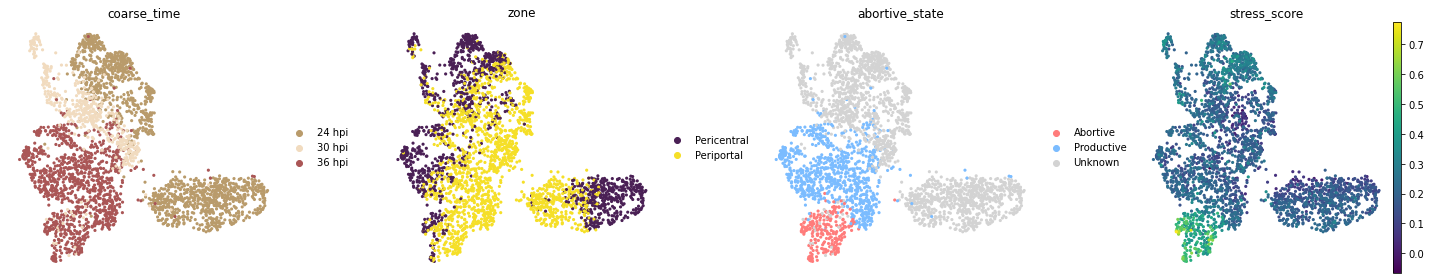

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, c in enumerate(["coarse_time", "zone", "abortive_state", "stress_score"]):
    sc.pl.umap(adata, color=[c], ax=axs[i], show=False)
    axs[i].set_axis_off()
plt.tight_layout()

As we can see above, for 24 and 30 hpi the `abortive_state` is unknown. We would like to use `biolord-classify` to classify these cells.

By calling {meth}`biolord.Biolord.setup_anndata()` we set the semi-supervised attributes used for disentanglement. 
The function takes as input:
* `adata`: the adata object for the setting.
* `ordered_attributes_keys`: the keys in {attr}`anndata.AnnData.obs` or {attr}`anndata.AnnData.obsm` defining ordered attributes.
* `categorical_attributes_keys`: the keys in {attr}`anndata.AnnData.obs` defining categorical attributes.
* `categorical_attributes_missing`: a dict containing all `categorical_attributes_keys` as keys. For each key, the value is the category that should be treated as the unknown label (if it contains missing labels) otherwise set to None. Here we will pass `"abortive_state":"Unknown"` and set the rest to `None`.

In [5]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=["stress_score"],
    categorical_attributes_keys=["time_int", "abortive_state", "zone"],
    categorical_attributes_missing={"time_int": None, "abortive_state": "Unknown", "zone": None},
)

In [6]:
adata

AnnData object with n_obs × n_vars = 3024 × 1949
    obs: 'barcode', 'mouse', 'marker', 'time', 'infected', 'experiment', 'coarse_time', 'MB', 'eta', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_qc', 'SUMPBA', 'n_counts', 'n_genes', 'mus_rRNA', 'pba_rRNA', 'pba_rRNA_fraction', 'nCount_PBA', 'nFeature_PBA', 'nCount_MUS', 'nFeature_MUS', 'RNA_snn_res.0.2', 'seurat_clusters', 'MBinfected', 'cluster_names', 'ident', 'eta_normalized', 'nCounts_tot', 'normalized_PBA', 'coarse_time_orig', 'zone', 'status', 'status_control', 'time_int', 'pseudotime', 'abortive', 'abortive_state', 'stress_score', 'split_random', '_indices', '_scvi_time_int', '_scvi_abortive_state', '_scvi_zone'
    var: 'org', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'abortive_state_colors', 'coarse_time_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'status_colors', 'status_control_colors', 'umap', 'zone_colors', '_scvi_uuid', '_scvi_manager_uuid'


## Run `biolord-classify`

### Instantiate a {class}`~biolord.Biolord` model

We instantiate the model given the `module_params`.

These are parameters required to construct the model's module, the various networks included in a `biolord-classify` model.

To the parameters defined to train a classic `biolord` model we add values related to the classification task:
* `classification_penalty`: penalty value for accuracy in training a regressor for ordered classes.
* `classifier_penalty`: the penalty weight of the classification term in the final loss objective.
* `classify_all`: a bool stating whether a classifier is trained for all attributes or only those with missing labels.
* `classifier_dropout_rate`: dropout rate for the classifiers

In [7]:
module_params = {
    "decoder_width": 512,
    "decoder__depth": 4,
    "attribute_nn_width": 512,
    "attribute_nn_depth": 4,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "unknown_attribute_noise_param": 1e-1,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 4,
    "loss_ae": "gauss",
    "loss_regression": "gauss",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e2,
    "attribute_dropout_rate": 0.05,
    "eval_r2_ordered": False,
    "classifier_penalty": 1e1,
    "classification_penalty": 0,
    "classify_all": False,
    "classifier_dropout_rate": 0.05,
}

To instantiate the {class}`~biolord.BiolordClassifyModule`, we pass `train_classifiers=True` to {class}`biolord.Biolord` model.

In [8]:
model = biolord.Biolord(
    adata=adata,
    n_latent=32,
    model_name="spatiotemporal_malaria_abortive",
    train_classifiers=True,
    module_params=module_params,
    split_key="split_random",
)

[rank: 0] Global seed set to 42


### Train the model

To train the model we provide `trainer_params`. These are paramters which dictate the training regime, e.g., learning rate, weight decay and scheduler type.

In [9]:
trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 90,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [10]:
model.train(
    max_epochs=200,
    batch_size=256,
    plan_kwargs=trainer_params,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
    enable_checkpointing=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 90/200:  45%|████▌     | 90/200 [02:00<02:27,  1.34s/it, v_num=1, val_generative_mean_accuracy=0.963, val_generative_var_accuracy=0.802, val_biolord_metric=0.916, val_reconstruction_loss=0.728, val_unknown_attribute_penalty_loss=26.5, val_classification_accuracy=0.982, val_regression_r2_accuracy=0, val_regression_mse=0, val_classification_loss=0.395, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=0.631, unknown_attribute_penalty_loss=31.4, classification_accuracy=0, regression_r2_accuracy=0, regression_mse=0, classification_loss=0.326]
Monitored metric val_biolord_metric did not improve in the last 20 records. Best score: 0.925. Signaling Trainer to stop.


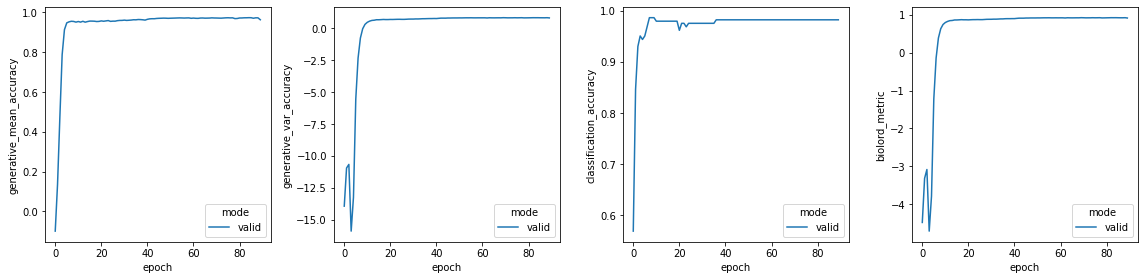

In [11]:
vals = ["generative_mean_accuracy", "generative_var_accuracy", "classification_accuracy", "biolord_metric"]
fig, axs = plt.subplots(nrows=1, ncols=len(vals), figsize=(4 * len(vals), 4))

model.epoch_history = pd.DataFrame.from_dict(model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history[model.epoch_history["mode"] == "valid"],
        ax=axs[i],
    )

plt.tight_layout()

## Get the `Abortive` state classification

Given the trained model we turn to classify cells at 24 and 30 hpi as `Abortive/Productive`.

In [12]:
idx_predict = np.where((adata.obs["coarse_time"] != "36 hpi"))[0]

adata_predict = adata[idx_predict].copy()

In [13]:
labels_color = {
    "coarse_time": "coarse time",
    "zone": "zone",
    "abortive_state_classification": "abortive (classification)",
    "abortive_state": "abortive (label)",
}

abortive_color = {
    "Abortive": "#ff7c7b",
    "Productive": "#7bbcff",
    "Unknown": "#BDBABB",
}

coarse_time_colors = {"24 hpi": "#B99B6B", "30 hpi": "#F1DBBF", "36 hpi": "#AA5656"}

save_names = {"all": "all"}

In [14]:
datasets = {}
classification = {}

dataset = model.get_dataset(adata)
classification = model.module.classify(dataset["X"])

for attribute_, vals_ in classification.items():
    if attribute_ in model.categorical_attributes_map:
        inv_map = {v: k for k, v in model.categorical_attributes_map[attribute_].items()}
        adata.obs[f"{attribute_}_classification"] = [inv_map[k] for k in vals_.argmax(dim=-1).cpu().numpy()]
    else:
        adata.obs[f"{attribute_}_classification"] = vals_[0].detach().cpu().numpy()

for attribute_, vals_ in classification.items():
    adata.obs[f"{attribute_}_classification"] = adata.obs[f"{attribute_}_classification"].astype("category")
    adata.obs[f"{attribute_}_classification_str"] = adata.obs[f"{attribute_}_classification"].copy()
    adata.obs[f"{attribute_}_classification"] = adata.obs[f"{attribute_}_classification"].cat.rename_categories(
        lambda x: str(x) + "\n(biolord-classify)"
    )


sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

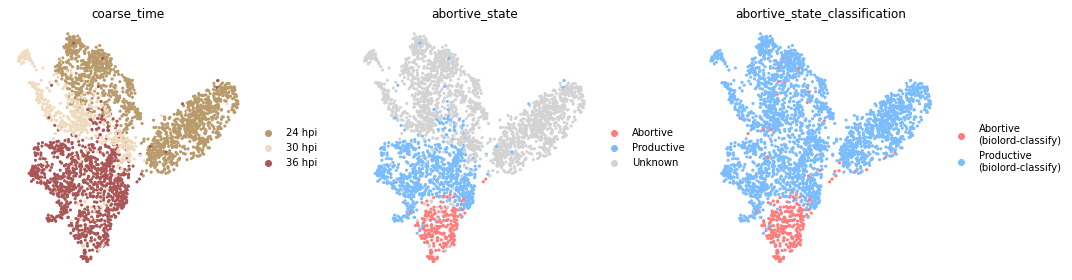

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
adata.uns["abortive_state_classification_colors"] = adata.uns["abortive_state_colors"][:2]

for i, c in enumerate(["coarse_time", "abortive_state", "abortive_state_classification"]):
    sc.pl.umap(adata, color=[c], ax=axs[i], show=False)
    axs[i].set_axis_off()
plt.tight_layout()

## Evaluate classification

We start by validating the classification accuracy with respect to labeled cells (36 hpi).

In [16]:
acc = (
    adata[adata.obs["abortive_state"].isin(["Abortive", "Productive"])].obs["abortive_state"]
    == adata[adata.obs["abortive_state"].isin(["Abortive", "Productive"])].obs["abortive_state_classification_str"]
).sum() / adata.obs["abortive_state"].isin(["Abortive", "Productive"]).sum()
print(f"abortive state classification accuracy is: {acc:.2f}")

abortive state classification accuracy is: 1.00


### Population ratio

Next we can look at the proportion of the `Abortive/Productive` populations.
Note that according to {cite}`afriat:22` at earlier time points the `Abortive` population is expected to be small, $\sim2-5\%$.

In [17]:
hpis = {}
for hpi in adata.obs["coarse_time"].cat.categories:
    hpis[hpi] = (
        adata[adata.obs["coarse_time"].isin([hpi])].obs["abortive_state_classification"].value_counts()
        / adata[adata.obs["coarse_time"].isin([hpi])].shape[0]
    ).to_dict()
df_hpis = pd.DataFrame(hpis).T.reset_index()
df_hpis

,index,Productive\n(biolord-classify),Abortive\n(biolord-classify)
0,24 hpi,0.984160,0.015840
1,30 hpi,0.942740,0.057260
2,36 hpi,0.784857,0.215143


### Spatial and parasite mRNA distribution

Following the properties of 36 hpi we expect the abortive population to be Periportally biased and present low parasite mRNA counts.

In [18]:
adata.obs["label_type"] = "biolord-classify"
adata.obs.loc[adata.obs["coarse_time"] == "36 hpi", "label_type"] = "original"

In [19]:
pairs = [
    [("biolord-classify", "Abortive\n(biolord-classify)"), ("biolord-classify", "Productive\n(biolord-classify)")],
    [("original", "Abortive\n(biolord-classify)"), ("original", "Productive\n(biolord-classify)")],
]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive
(biolord-classify) vs. original_Productive
(biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.170e-53 U_stat=3.396e+04
biolord-classify_Abortive
(biolord-classify) vs. biolord-classify_Productive
(biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.192e-11 U_stat=2.253e+04


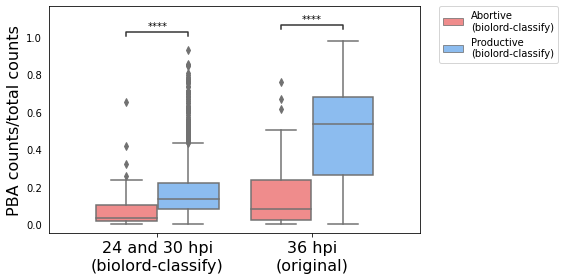

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

df = adata.obs[
    [
        "label_type",
        "abortive_state_classification",
        "normalized_PBA",
        "eta_normalized",
        "zone",
        "coarse_time",
        "pseudotime",
    ]
]
plotting_parameters = {
    "data": df,
    "x": "label_type",
    "y": "normalized_PBA",
    "hue": "abortive_state_classification",
    "palette": adata.uns["abortive_state_classification_colors"],
}

sns.boxplot(**plotting_parameters)

# Add annotations
annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(test="Mann-Whitney", comparisons_correction="Benjamini-Hochberg").apply_and_annotate()

ax.set_xlabel("")
ax.set_ylabel("PBA counts/total counts", fontsize=16)
ax.set_xticklabels(["24 and 30 hpi\n(biolord-classify)", "36 hpi\n(original)"], fontsize=16)
ax.yaxis.set_ticks_position("none")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original_Abortive
(biolord-classify) vs. original_Productive
(biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.056e-04 U_stat=1.143e+05
biolord-classify_Abortive
(biolord-classify) vs. biolord-classify_Productive
(biolord-classify): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.546e-05 U_stat=6.396e+04


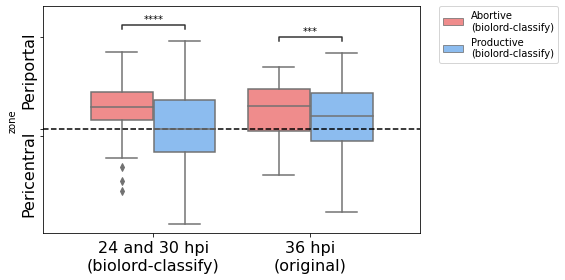

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plotting_parameters = {
    "data": df,
    "x": "label_type",
    "y": "eta_normalized",
    "hue": "abortive_state_classification",
    "palette": adata.uns["abortive_state_classification_colors"],
}
sns.boxplot(**plotting_parameters)

# Add annotations
annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(test="Mann-Whitney", comparisons_correction="Benjamini-Hochberg").apply_and_annotate()

th = adata[adata.obs["zone"] == "Pericentral"].obs["eta_normalized"].max()
ax.axhline(th, linestyle="--", color="black")
ax.set_xlabel("")
ax.set_ylabel("zone")
ax.set_yticks([0.48, th, 0.98])
ax.set_yticklabels(["Pericentral", "", "Periportal"], rotation=90, fontsize=16)
ax.set_xticklabels(["24 and 30 hpi\n(biolord-classify)", "36 hpi\n(original)"], fontsize=16)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()

plt.show()

### Interferon response

At last, we can evaluate gene interferon response trajectory using representative genes.

In [22]:
adata.obs["time_abortive_classification"] = (
    adata.obs["coarse_time"].astype(str) + " (" + adata.obs["abortive_state_classification"].astype(str) + ")"
)
adata.obs["time_abortive_classification"] = adata.obs["time_abortive_classification"].astype("category")

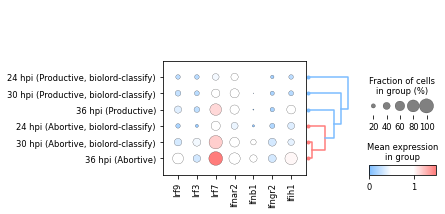

In [23]:
abortive_color = {
    "Abortive": "#ff7c7b",
    "Productive": "#7bbcff",
}

df_ifnr = adata.obs[["time_abortive_classification"]].reset_index()
for gene in ["Irf9", "Irf3", "Irf7", "Ifnar2", "Ifnb1", "Ifngr2", "Ifih1"]:
    df_ifnr.loc[:, gene] = adata.X[:, adata.var_names.isin([gene])]
df_ifnr = df_ifnr.groupby("time_abortive_classification").mean()

sc.tl.dendrogram(adata, groupby="time_abortive_classification", linkage_method="centroid")

axs = sc.pl.dotplot(
    adata,
    ["Irf9", "Irf3", "Irf7", "Ifnar2", "Ifnb1", "Ifngr2", "Ifih1"],
    groupby="time_abortive_classification",
    cmap=sns.blend_palette([abortive_color["Productive"], "1", "1", abortive_color["Abortive"]], as_cmap=True),
    dendrogram=True,
    show=False,
    return_fig=True,
)

yticklabels = axs.get_axes()["mainplot_ax"].get_yticklabels()
yticklabels_new = []
node_colors = []
for ti, tick in enumerate(yticklabels):
    if "36" in tick.get_text():
        yticklabels_new.append(" ".join(tick.get_text().split("\n")[:1]) + ")")
    else:
        yticklabels_new.append(" ".join(tick.get_text().split("\n")[:1]) + ", biolord-classify)")

    if "Abortive" in tick.get_text():
        node_colors.append(abortive_color["Abortive"])
    else:
        node_colors.append(abortive_color["Productive"])

axs.get_axes()["mainplot_ax"].set_yticklabels(yticklabels_new)

for li, line in enumerate(axs.get_axes()["group_extra_ax"].get_lines()):
    line.set_color(node_colors[-(li + 2)])

nodes = axs.get_axes()["group_extra_ax"].get_yticks()
for ni, node in enumerate(nodes):
    axs.get_axes()["group_extra_ax"].plot(0, node, ".", color=node_colors[ni])